Todo:
* Need to plot some profiles to check the error introduced due to the linear interpolation from the irregularly spaced grid to the regularly spaced grid in (rho,z) space. Is the error acceptable? 
* See if we can learn a reduced representation of alpha (without coordinate information, how would we include coordinate system info?)

# Dependencies

In [33]:
from pymagdisc.data.load_data import load_model
from pymagdisc.vis.plot_mdisc import plot_2d_cmp_exp_Pcold, plot_2d_cmp_exp_jphi
from pymagdisc.vis.plot_compare_contours_alpha import plot_compare_contours_alpha
from pymagdisc import config
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import warnings
from glob import glob
import pickle
import numpy as np
import util
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 14})

In [128]:
import importlib
from pymagdisc.vis import plot_compare_contours_alpha
import util
importlib.reload(plot_compare_contours_alpha)
importlib.reload(util)

<module 'util' from '/home/ikc19/PhD/Code/mdisc/util.py'>

In [2]:
config.PATH_TO_DATA

'/home/ikc19/PhD/Code/mdisc/mdiscnet/data/MDISC/small_dataset/'

# Load data

In [3]:
MD_EXP = load_model(f'{config.PATH_TO_DATA}jup_mdisc_kh1.52e+07_rmp69.00_nr601_nmu601.mat');
MD_CMP = load_model(f'{config.PATH_TO_DATA}jup_mdisc_kh1.52e+07_rmp60.00_nr601_nmu601.mat');

# Plot reference disc models

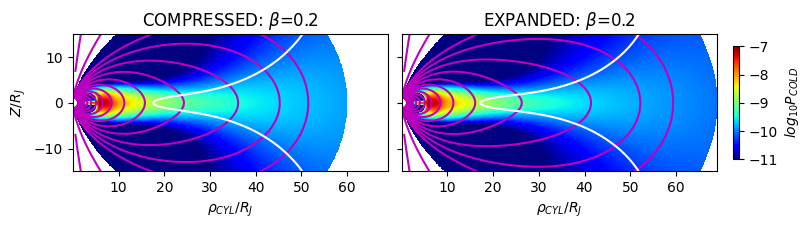

In [7]:
plot_2d_cmp_exp_Pcold(MD_CMP, MD_EXP)

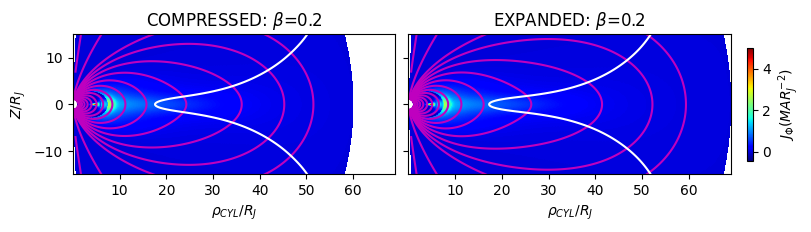

In [8]:
plot_2d_cmp_exp_jphi(MD_CMP, MD_EXP)

# Create v2d_B dataset with targets
The targets are the corresponding `Kh` and `rmp`.MD_EXP["c2d"]["rho"]

In [10]:
MD_EXP.keys()

dict_keys(['param', 'opts', 'info', 'consts', 'planet', 'disc', 'scales', 'dims', 'c2d', 'v2d', 'v1d', 'jacpoly', 'omega_relax', 'alpha_relax', 'itnr'])

Text(0, 0.5, '$\\mu$')

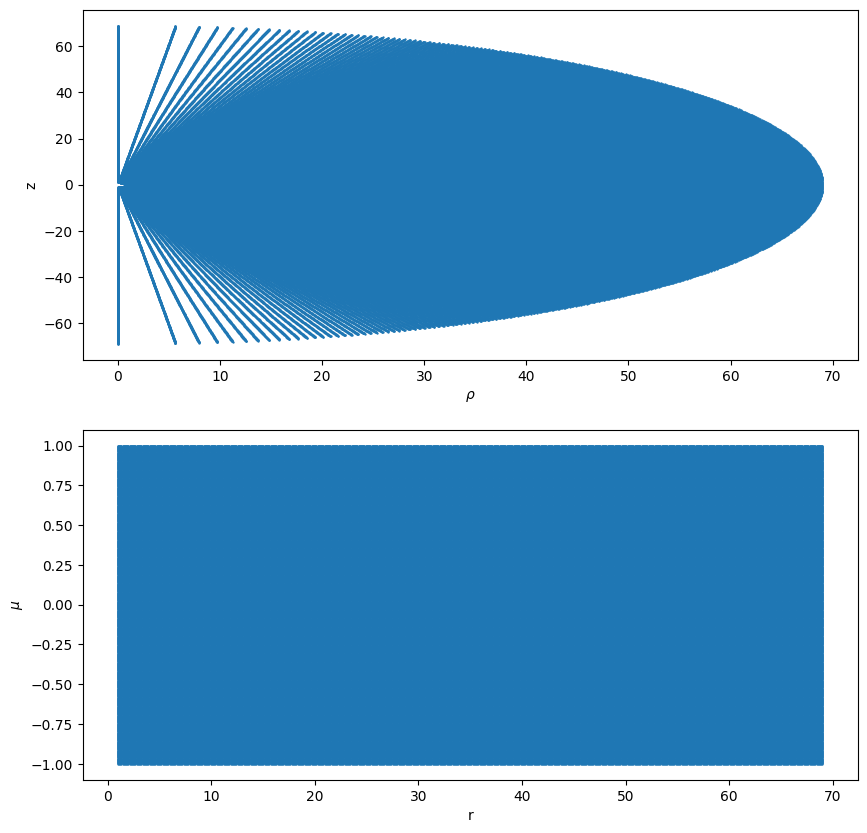

In [8]:
# visualize the r-\mu and z-\rho grid on which the mdisc model was created
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].scatter(MD_EXP["c2d"]["rho"], MD_EXP["c2d"]["z"], s=0.5)
ax[0].set_xlabel(r'$\rho$')
ax[0].set_ylabel('z')

ax[1].scatter(MD_EXP["c2d"]["r"], MD_EXP["c2d"]["mu"], s=0.5)
ax[1].set_xlabel('r')
ax[1].set_ylabel(r'$\mu$')

* Spherical coordinate (r and $\mu$) grid is uniform
* Cylindrical coordinate ($\rho$ and z) grid is not uniform 

We could save both representations to make two sets of training data and see which one performs better.

## $\rho z$ plane 

In [101]:
# find the min 
np.min(MD_EXP["c2d"]["rho"]), np.max(MD_EXP["c2d"]["rho"]), np.min(MD_EXP["c2d"]["z"]), np.max(MD_EXP["c2d"]["z"]), 

(0.0, 69.0, -69.0, 69.0)

In [37]:
# resample the grid to make uniform 
width = 512
height = 512
xi, yi, zi = util.resample_irreg2regGrid(x=MD_EXP["c2d"]["rho"],
                            y=MD_EXP["c2d"]["z"],
                            z=MD_EXP["v2d"]["B"],
                            xi=np.linspace(np.min(MD_EXP["c2d"]["rho"]), np.max(MD_EXP["c2d"]["rho"]), width),
                            yi=np.linspace(np.min(MD_EXP["c2d"]["z"]), np.max(MD_EXP["c2d"]["z"]), height),
                            method='linear')

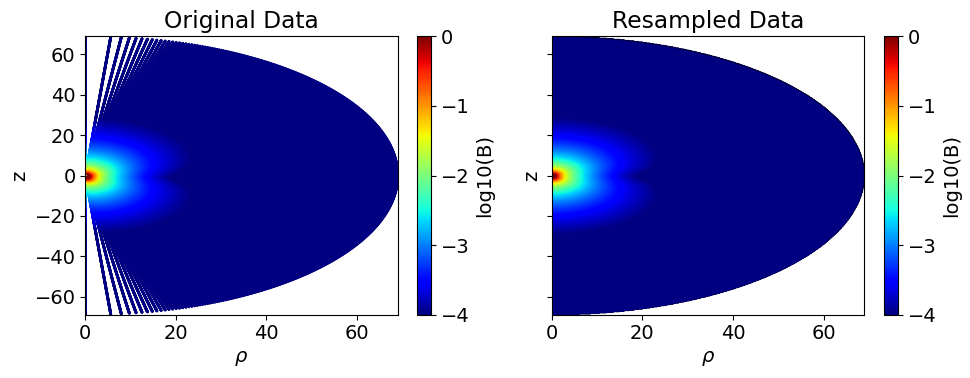

In [38]:
# Plot the original and resampled data
fig, ax = plt.subplots(1,2,figsize=(10, 4), sharex=True, sharey=True)

s = ax[0].scatter(MD_EXP["c2d"]["rho"],
            MD_EXP["c2d"]["z"],
            c=np.log10(MD_EXP["v2d"]["B"]),
            s=1,
        vmin=-4,
        vmax=0,
        cmap="jet",)
ax[0].set_xlabel(r'$\rho$')
ax[0].set_ylabel('z')
ax[0].set_title('Original Data')
plt.colorbar(s, label='log10(B)', ax=ax[0])

pc = ax[1].pcolormesh(xi, yi, np.log10(zi),
        shading="gouraud",
        vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_xlabel(r'$\rho$')
ax[1].set_ylabel('z')
ax[1].set_title('Resampled Data')
plt.colorbar(pc, label='log10(B)', ax=ax[1])

plt.tight_layout()
plt.show()


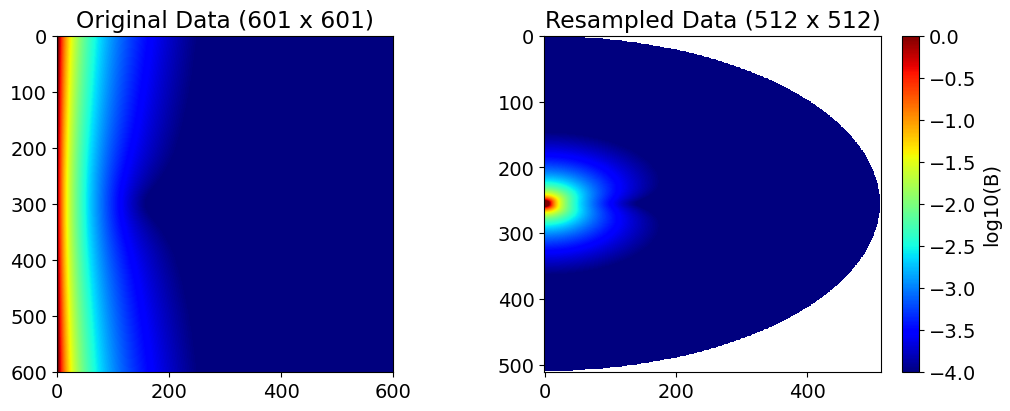

In [40]:
# interpolated data (on a regular grid) can be plotted with imshow as an image
fig, ax = plt.subplots(1,2,figsize=(10, 4), constrained_layout=True)

s = ax[0].imshow(np.log10(MD_EXP["v2d"]["B"]), vmin=-4,
        vmax=0, 
        cmap="jet")
ax[0].set_title('Original Data (601 x 601)')

s = ax[1].imshow(np.log10(zi), vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_title('Resampled Data (512 x 512)')
plt.colorbar(s, label='log10(B)', ax=ax[1])

In [ ]:
# save the original v2d data
filenames = glob(f"{config.PATH_TO_DATA}*.mat")
samples_v2d_B = []
samples_target = []
for filename in tqdm(filenames):
    filename_split = filename.split('_')
    MD = load_model(filename)
    samples_v2d_B.append(MD["v2d"]["B"])
    samples_target.append(filename_split[3] + '_' + filename_split[4])


In [55]:
width=601
height=601
samples_v2d_B = np.array(samples_v2d_B).reshape(-1,width,height,1) # (nSamples,width,height,nChannels)
util.save_result(samples_v2d_B, config.PATH_TO_DATA+'samples_v2d_B_rmu_601x601.pkl')
util.save_result(np.array(samples_target), config.PATH_TO_DATA+'samples_target.pkl')

In [56]:
np.array(samples_v2d_B).shape, samples_target

((15, 601, 601, 1),
 ['kh1.52e+07_rmp63.50',
  'kh1.52e+07_rmp62.50',
  'kh1.52e+07_rmp60.00',
  'kh1.52e+07_rmp63.00',
  'kh1.52e+07_rmp61.50',
  'kh1.52e+07_rmp62.00',
  'kh1.52e+07_rmp60.50',
  'kh1.52e+07_rmp65.00',
  'kh1.52e+07_rmp67.50',
  'kh1.52e+07_rmp64.50',
  'kh1.52e+07_rmp66.00',
  'kh1.52e+07_rmp67.00',
  'kh1.52e+07_rmp68.50',
  'kh1.52e+07_rmp68.00',
  'kh1.52e+07_rmp69.00'])

In [57]:
# save the interpolated regularly spaced v2d data
filenames = glob(f"{config.PATH_TO_DATA}*.mat")
width = 512
height = 512
samples_v2d_B = []
samples_target = []
for filename in tqdm(filenames):
    filename_split = filename.split('_')
    MD = load_model(filename)
    xi, yi, zi = util.resample_irreg2regGrid(x=MD["c2d"]["rho"],
                            y=MD["c2d"]["z"],
                            z=MD["v2d"]["B"],
                            xi=np.linspace(np.min(MD["c2d"]["rho"]), np.max(MD["c2d"]["rho"]), width),
                            yi=np.linspace(np.min(MD["c2d"]["z"]), np.max(MD["c2d"]["z"]), height),
                            method='linear')
    samples_v2d_B.append(zi)
    samples_target.append(filename_split[3] + '_' + filename_split[4])

samples_v2d_B = np.array(samples_v2d_B).reshape(-1,width,height,1) # (nSamples,width,height,nChannels)
util.save_result(samples_v2d_B, config.PATH_TO_DATA+'samples_v2d_B_rhoz_512x512.pkl')
#util.save_result(np.array(samples_target), config.PATH_TO_DATA+'samples_target.pkl')

100%|██████████| 15/15 [01:52<00:00,  7.47s/it]


In [58]:
samples_v2d_B.shape

(15, 512, 512, 1)

## $r\mu$ plane

In [11]:
# resample the grid to make uniform 
width = 512
height = 512
xi, yi, zi = util.resample_irreg2regGrid(x=MD_EXP["c2d"]["r"],
                            y=MD_EXP["c2d"]["mu"],
                            z=MD_EXP["v2d"]["B"],
                            xi=np.linspace(np.min(MD_EXP["c2d"]["r"]), np.max(MD_EXP["c2d"]["r"]), width),
                            yi=np.linspace(np.min(MD_EXP["c2d"]["mu"]), np.max(MD_EXP["c2d"]["mu"]), height),
                            method='linear')

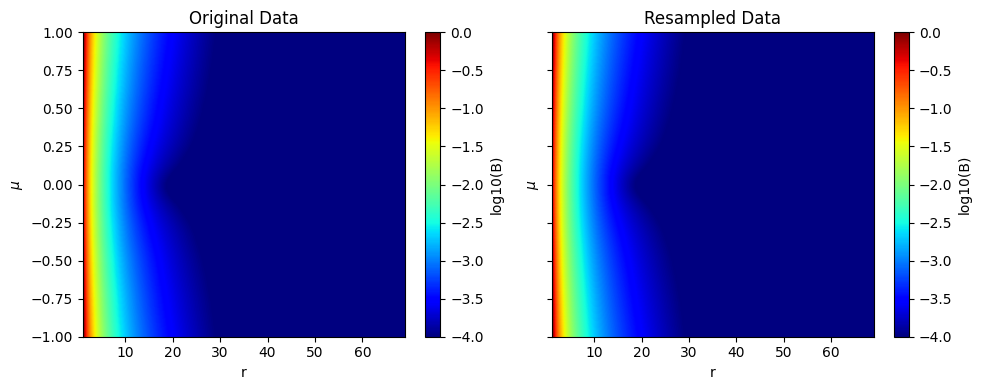

In [12]:
# Plot the original and resampled data
fig, ax = plt.subplots(1,2,figsize=(10, 4), sharex=True, sharey=True)

s = ax[0].scatter(MD_EXP["c2d"]["r"],
            MD_EXP["c2d"]["mu"],
            c=np.log10(MD_EXP["v2d"]["B"]),
            s=1,
        vmin=-4,
        vmax=0,
        cmap="jet",)
ax[0].set_xlabel('r')
ax[0].set_ylabel(r'$\mu$')
ax[0].set_title('Original Data')
plt.colorbar(s, label='log10(B)', ax=ax[0])

pc = ax[1].pcolormesh(xi, yi, np.log10(zi),
        shading="gouraud",
        vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_xlabel('r')
ax[1].set_ylabel(r'$\mu$')
ax[1].set_title('Resampled Data')
plt.colorbar(pc, label='log10(B)', ax=ax[1])

plt.tight_layout()
plt.show()

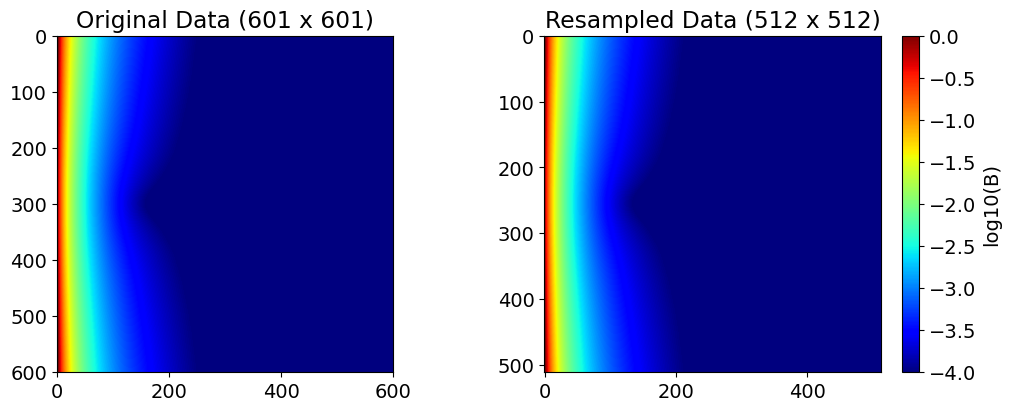

In [36]:
# interpolated data (on a regular grid) can be plotted with imshow as an image
fig, ax = plt.subplots(1,2,figsize=(10, 4), constrained_layout=True)

s = ax[0].imshow(np.log10(MD_EXP["v2d"]["B"]), vmin=-4,
        vmax=0, 
        cmap="jet")
ax[0].set_title('Original Data (601 x 601)')

s = ax[1].imshow(np.log10(zi), vmin=-4,
        vmax=0,
        cmap="jet")
ax[1].set_title('Resampled Data (512 x 512)')
plt.colorbar(s, label='log10(B)', ax=ax[1])

         

In [60]:
# save the interpolated regularly spaced v2d data
filenames = glob(f"{config.PATH_TO_DATA}*.mat")
width = 512
height = 512
samples_v2d_B = []
samples_target = []
for filename in tqdm(filenames):
    filename_split = filename.split('_')
    MD = load_model(filename)
    xi, yi, zi = util.resample_irreg2regGrid(x=MD["c2d"]["r"],
                            y=MD["c2d"]["mu"],
                            z=MD["v2d"]["B"],
                            xi=np.linspace(np.min(MD["c2d"]["r"]), np.max(MD["c2d"]["r"]), width),
                            yi=np.linspace(np.min(MD["c2d"]["mu"]), np.max(MD["c2d"]["mu"]), height),
                            method='linear')
    samples_v2d_B.append(zi)
    samples_target.append(filename_split[3] + '_' + filename_split[4])
    
samples_v2d_B = np.array(samples_v2d_B).reshape(-1,width,height,1) # (nSamples,nChannels,width,height)
util.save_result(samples_v2d_B, config.PATH_TO_DATA+'samples_v2d_B_rmu_512x512.pkl')
#util.save_result(np.array(samples_target), config.PATH_TO_DATA+'samples_target.pkl')

100%|██████████| 15/15 [01:57<00:00,  7.81s/it]


In [61]:
samples_v2d_B.shape

(15, 512, 512, 1)

# Modify saved data

In [50]:
# rotate data
width = height = 512
samples_v2d_B = load.load_result(config.PATH_TO_DATA+'samples_v2d_B_rmu_512x512.pkl')
samples_v2d_B = samples_v2d_B.reshape(-1,width,height,1) # (nSamples,nChannels,width,height)


In [51]:
samples_v2d_B.shape

(15, 512, 512, 1)

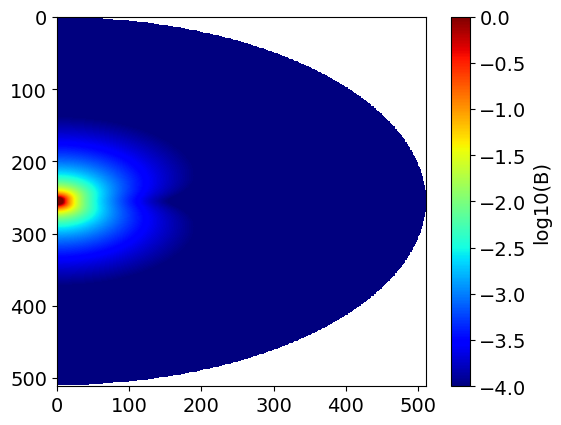

In [52]:
# verify it is still correct
s = plt.imshow(np.log10(samples_v2d_B[0]), vmin=-4,
        vmax=0,
        cmap="jet")
plt.colorbar(s, label='log10(B)')

In [48]:
# save
util.save_result(samples_v2d_B, config.PATH_TO_DATA+'samples_v2d_B_rmu_512x512.pkl')